In [1]:
import numpy as np
import pandas as pd
import io, sys, os
from tqdm import tqdm

import torch
import torch.nn as nn
import torchvision

from livelossplot import PlotLosses
from sklearn.metrics import classification_report, f1_score
import torchtext

from jupyterthemes import jtplot
jtplot.style()

sys.path.insert(0, '..\helpers')
from helpers import *

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

device = "cuda:0" if torch.cuda.is_available() else "cpu"

Using TensorFlow backend.


In [2]:
dataset = pd.read_csv('../data/train.txt', sep='\t')
dataset['turn1'] = dataset['turn1'].apply(normalize)
dataset['turn2'] = dataset['turn2'].apply(normalize)
dataset['turn3'] = dataset['turn3'].apply(normalize)

test_dataset = pd.read_csv('../data/dev.txt', sep='\t')
test_dataset['turn1'] = test_dataset['turn1'].apply(normalize)
test_dataset['turn2'] = test_dataset['turn2'].apply(normalize)
test_dataset['turn3'] = test_dataset['turn3'].apply(normalize)

test1_dataset = pd.read_csv('../data/dev.txt', sep='\t')
test1_dataset['turn1'] = test1_dataset['turn1'].apply(normalize)
test1_dataset['turn2'] = test1_dataset['turn2'].apply(normalize)
test1_dataset['turn3'] = test1_dataset['turn3'].apply(normalize)
test1_dataset['label'] = test1_dataset['label'].apply(lambda x: 'not-others' if x != 'others' else 'others')

test2_dataset = pd.read_csv('../data/dev.txt', sep='\t')
test2_dataset = test2_dataset[ test2_dataset['label'] != 'others' ]
test2_dataset['turn1'] = test2_dataset['turn1'].apply(normalize)
test2_dataset['turn2'] = test2_dataset['turn2'].apply(normalize)
test2_dataset['turn3'] = test2_dataset['turn3'].apply(normalize)

tier1_dataset = pd.read_csv('../data/train.txt', sep='\t')
tier1_dataset['turn1'] = tier1_dataset['turn1'].apply(normalize)
tier1_dataset['turn2'] = tier1_dataset['turn2'].apply(normalize)
tier1_dataset['turn3'] = tier1_dataset['turn3'].apply(normalize)
tier1_dataset['label'] = tier1_dataset['label'].apply(lambda x: 'not-others' if x != 'others' else 'others')

tier2_dataset = pd.read_csv('../data/train.txt', sep='\t')
tier2_dataset = tier2_dataset[ tier2_dataset['label'] != 'others' ]
tier2_dataset['turn1'] = tier2_dataset['turn1'].apply(normalize)
tier2_dataset['turn2'] = tier2_dataset['turn2'].apply(normalize)
tier2_dataset['turn3'] = tier2_dataset['turn3'].apply(normalize)

In [3]:
label_tokenizer = Tokenizer(num_words=None, filters='')
label_tokenizer.fit_on_texts(dataset['label'].tolist())

label1_tokenizer = Tokenizer(num_words=None, filters='')
label1_tokenizer.fit_on_texts(tier1_dataset['label'].tolist())

label2_tokenizer = Tokenizer(num_words=None, filters='')
label2_tokenizer.fit_on_texts(tier2_dataset['label'].tolist())

with open('../_files/corpus.txt', 'r', encoding='utf8') as f:
    corpus = f.readlines()
    corpus = [line.strip() for line in corpus]
    tokenizer = Tokenizer(num_words=None, filters='')
    tokenizer.fit_on_texts(corpus)

t1_data, t1_turn1_len, t1_turn2_len, t1_turn3_len = make_tensors(tier1_dataset, tokenizer, label1_tokenizer)
t1_label_index = dict([[v-1,k] for k,v in label1_tokenizer.word_index.items()])

t2_data, t2_turn1_len, t2_turn2_len, t2_turn3_len = make_tensors(tier2_dataset, tokenizer, label2_tokenizer)
t2_label_index = dict([[v-1,k] for k,v in label2_tokenizer.word_index.items()])

te1_data, te1_turn1_len, te1_turn2_len, te1_turn3_len = make_tensors(test1_dataset, tokenizer, label1_tokenizer)
te2_data, te2_turn1_len, te2_turn2_len, te2_turn3_len = make_tensors(test2_dataset, tokenizer, label2_tokenizer)

data, turn1_len, turn2_len, turn3_len = make_tensors(dataset, tokenizer, label_tokenizer)
te_data, te_turn1_len, te_turn2_len, te_turn3_len = make_tensors(test_dataset, tokenizer, label_tokenizer)

In [4]:
custom_embeddings = get_embedding_matrix(tokenizer.word_index, 'custom_vectors_V2.5_2500.txt', 100).float()
fasttext_embeddings = get_embedding_matrix(tokenizer.word_index, 'vectors.txt', 300).float()

no custom vector for  🎁
no custom vector for  👄
no custom vector for  🐇
no custom vector for  👿
no custom vector for  🌷
no custom vector for  💓
no custom vector for  👫
no custom vector for  🏼
no custom vector for  💛
no custom vector for  🏿
no custom vector for  💤
no custom vector for  👉
no custom vector for  🤒
no custom vector for  👵
no custom vector for  👆
no custom vector for  🙃
no custom vector for  chuck
no custom vector for  👅
no custom vector for  🙋
no custom vector for  🏽
no custom vector for  👪
no custom vector for  🤘
no custom vector for  poker
no custom vector for  💅
no custom vector for  🕺
no custom vector for  hop
no custom vector for  guest
no custom vector for  hockey
no custom vector for  🐣
no custom vector for  👼
no custom vector for  👭
no custom vector for  🐻
no custom vector for  👙
no custom vector for  🍞
no custom vector for  🙍
no custom vector for  👶
no custom vector for  😙
no custom vector for  events
no custom vector for  greeting
no custom vector for  multiplicat

no custom vector for  mosquitoes
no custom vector for  mosquitos
no custom vector for  pearl
no custom vector for  uninstalled
no custom vector for  ceo's
no custom vector for  daisy
no custom vector for  scariest
no custom vector for  smoking
no custom vector for  anf
no custom vector for  leftovers
no custom vector for  cristiano
no custom vector for  diameter
no custom vector for  🖑
no custom vector for  🚘
no custom vector for  🍰
no custom vector for  🐞
no custom vector for  🐝
no custom vector for  🐬
no custom vector for  🐛
no custom vector for  🎶
no custom vector for  🍌
no custom vector for  🔙
no custom vector for  🔜
no custom vector for  boob's
no custom vector for  📲
no custom vector for  🎧
no custom vector for  🏣
no custom vector for  i'nt
no custom vector for  🤷
no custom vector for  👺
no custom vector for  🐘
no custom vector for  💯
no custom vector for  🎃
no custom vector for  💵
no custom vector for  minions
no custom vector for  pressuring
no custom vector for  pz
no custom v

no custom vector for  nutmeg
no custom vector for  mrunal
no custom vector for  asso
no custom vector for  gve
no custom vector for  fig
no custom vector for  drawin
no custom vector for  emojifortune
no custom vector for  samething
no custom vector for  trader
no custom vector for  dw
no custom vector for  'programmed
no custom vector for  genes'
no custom vector for  vakola
no custom vector for  a's
no custom vector for  weekend's
no custom vector for  'blocking
no custom vector for  nashik
no custom vector for  wokayyy
no custom vector for  indie
no custom vector for  alt
no custom vector for  sixty
no custom vector for  sunset
no custom vector for  fuckbuddy
no custom vector for  kesi
no custom vector for  favoriet
no custom vector for  'time
no custom vector for  'sons
no custom vector for  plunder'
no custom vector for  lucifer
no custom vector for  bhaskars
no custom vector for  'joke'
no custom vector for  rameswaram
no custom vector for  genious
no custom vector for  criticise

no custom vector for  labor
no custom vector for  rhi
no custom vector for  italia
no custom vector for  do'nt
no custom vector for  dout
no custom vector for  console
no custom vector for  krbo
no custom vector for  sage
no custom vector for  hahhaaa
no custom vector for  theb
no custom vector for  almigthy
no custom vector for  kanguage
no custom vector for  grin
no custom vector for  blobs
no custom vector for  4dx
no custom vector for  rave
no custom vector for  ☺☺tnx
no custom vector for  lists
no custom vector for  2;00
no custom vector for  milani
no custom vector for  nema
no custom vector for  heathen
no custom vector for  vessel
no custom vector for  pulka
no custom vector for  dana
no custom vector for  sura
no custom vector for  pokiri
no custom vector for  nsmer
no custom vector for  indifference
no custom vector for  reed
no custom vector for  sharply
no custom vector for  p'ming
no custom vector for  namba
no custom vector for  alcheringa
no custom vector for  visakhapat

no custom vector for  likered
no custom vector for  wh7
no custom vector for  *raises
no custom vector for  eyebrow*
no custom vector for  allianz
no custom vector for  owns
no custom vector for  listener
no custom vector for  *i*
no custom vector for  cp
no custom vector for  whitening
no custom vector for  introspect
no custom vector for  i’
no custom vector for  feelingyusohot
no custom vector for  ialsowithyu
no custom vector for  vada
no custom vector for  paragraphs
no custom vector for  void
no custom vector for  certificates
no custom vector for  pardon
no custom vector for  girlfriens
no custom vector for  technologies
no custom vector for  ted
no custom vector for  grader
no custom vector for  abide
no custom vector for  charting
no custom vector for  jannu
no custom vector for  milf
no custom vector for  thnq
no custom vector for  ❤️❤️you
no custom vector for  fetched
no custom vector for  bixby
no custom vector for  badam
no custom vector for  halwa
no custom vector for  bi

no custom vector for  hahais
no custom vector for  huricane
no custom vector for  lieying
no custom vector for  instal
no custom vector for  buger
no custom vector for  chairs}
no custom vector for  soundcloud
no custom vector for  namber
no custom vector for  pokee
no custom vector for  a5
no custom vector for  purse
no custom vector for  kissie
no custom vector for  f*
no custom vector for  queue
no custom vector for  operates
no custom vector for  informative
no custom vector for  oyo
no custom vector for  afternoin
no custom vector for  entourage
no custom vector for  daydream❤️
no custom vector for  kilpauk
no custom vector for  peroson
no custom vector for  vanakkam
no custom vector for  lettr
no custom vector for  blend
no custom vector for  45pm
no custom vector for  vibe
no custom vector for  recommendation
no custom vector for  beacome
no custom vector for  harshita
no custom vector for  thankfully
no custom vector for  upkg
no custom vector for  uuua
no custom vector for  wh

no custom vector for  intrsting
no custom vector for  oicher
no custom vector for  2chat
no custom vector for  linking
no custom vector for  corrupt
no custom vector for  sweater
no custom vector for  t'ya
no custom vector for  refrigeration
no custom vector for  instructions
no custom vector for  gatr
no custom vector for  bzy
no custom vector for  hahahhaaa
no custom vector for  hurricane
no custom vector for  peach
no custom vector for  branding
no custom vector for  maids
no custom vector for  squirt
no custom vector for  marrage
no custom vector for  'd
no custom vector for  chatt
no custom vector for  emotionol
no custom vector for  nudr
no custom vector for  y3s
no custom vector for  entity
no custom vector for  genitals
no custom vector for  300k
no custom vector for  tkt
no custom vector for  150
no custom vector for  multiplexes
no custom vector for  teligu
no custom vector for  ✍
no custom vector for  autogenerated
no custom vector for  deadbody
no custom vector for  aritifi

no custom vector for  yeaaaahhhh
no custom vector for  answer:
no custom vector for  altered
no custom vector for  oscillatory
no custom vector for  frequencies
no custom vector for  auditory
no custom vector for  sala
no custom vector for  namde
no custom vector for  dropbox
no custom vector for  agenda
no custom vector for  napkins
no custom vector for  giu
no custom vector for  adrs
no custom vector for  pw
no custom vector for  kas
no custom vector for  sooooooo
no custom vector for  hhehe
no custom vector for  courts
no custom vector for  unhealthy
no custom vector for  oily
no custom vector for  s*x
no custom vector for  helooooo
no custom vector for  11:04
no custom vector for  sealed
no custom vector for  skool
no custom vector for  toto's
no custom vector for  gracias
no custom vector for  estimated
no custom vector for  meeeeeeeeeeee
no custom vector for  encourage
no custom vector for  typings
no custom vector for  synonymous
no custom vector for  somnath
no custom vector fo

no custom vector for  oneplus
no custom vector for  crescent
no custom vector for  tbf
no custom vector for  ntv
no custom vector for  etv
no custom vector for  pataas
no custom vector for  analogy
no custom vector for  irrational
no custom vector for  analogous
no custom vector for  nonreal
no custom vector for  duuuuude
no custom vector for  stupic
no custom vector for  clicking
no custom vector for  'other
no custom vector for  discussions'
no custom vector for  discussions
no custom vector for  🌌
no custom vector for  🏂
no custom vector for  cinematic
no custom vector for  serous
no custom vector for  sexey
no custom vector for  warriors
no custom vector for  cavs
no custom vector for  snakes
no custom vector for  plague
no custom vector for  populated
no custom vector for  'today
no custom vector for  needyou
no custom vector for  👖
no custom vector for  🍤
no custom vector for  mabey
no custom vector for  destde
no custom vector for  görlitz
no custom vector for  smook
no custom v

no custom vector for  millionth
no custom vector for  dhoni's
no custom vector for  amazing❤
no custom vector for  downfall
no custom vector for  &gt;
no custom vector for  beaver
no custom vector for  okkh
no custom vector for  relationshpis
no custom vector for  erp
no custom vector for  xi
no custom vector for  defo
no custom vector for  anouing
no custom vector for  nmc
no custom vector for  maledive
no custom vector for  hunn
no custom vector for  eliminate
no custom vector for  posed
no custom vector for  postponed
no custom vector for  i'
no custom vector for  wayyyy
no custom vector for  soon❤️❤️
no custom vector for  bedside
no custom vector for  calculate
no custom vector for  hahaja
no custom vector for  occasions
no custom vector for  mustard
no custom vector for  beginners
no custom vector for  ooho
no custom vector for  that^
no custom vector for  756
no custom vector for  kilometers
no custom vector for  drenking
no custom vector for  2nights
no custom vector for  fires


no custom vector for  bolo
no custom vector for  violin
no custom vector for  whear
no custom vector for  autowala
no custom vector for  academics
no custom vector for  harrods
no custom vector for  drown
no custom vector for  boyfriend's
no custom vector for  launch
no custom vector for  bur
no custom vector for  modifications
no custom vector for  features
no custom vector for  fuuny
no custom vector for  mystic
no custom vector for  wording
no custom vector for  trigonometry
no custom vector for  4ever
no custom vector for  inspires
no custom vector for  luny
no custom vector for  marr
no custom vector for  b'coz
no custom vector for  formation
no custom vector for  admins
no custom vector for  pickles
no custom vector for  bathe
no custom vector for  dreamed
no custom vector for  thirsty
no custom vector for  diverting
no custom vector for  cauliflower
no custom vector for  jabh
no custom vector for  plezz
no custom vector for  6:05
no custom vector for  wachapp
no custom vector fo

no custom vector for  compete
no custom vector for  ☀
no custom vector for  strtd
no custom vector for  googlin
no custom vector for  dharm
no custom vector for  mister
no custom vector for  tlking
no custom vector for  'hostel'
no custom vector for  'mind'
no custom vector for  similarities
no custom vector for  carbon
no custom vector for  batra
no custom vector for  plea
no custom vector for  mistreat
no custom vector for  erecting
no custom vector for  penning
no custom vector for  3+2
no custom vector for  twas
no custom vector for  literacies
no custom vector for  eleven
no custom vector for  hotelier
no custom vector for  bartender
no custom vector for  bartenders
no custom vector for  okkkay
no custom vector for  butcher
no custom vector for  deepikas
no custom vector for  housefull
no custom vector for  ott
no custom vector for  liza
no custom vector for  dped
no custom vector for  helppp
no custom vector for  raferal
no custom vector for  shutdown
no custom vector for  shutdo

no custom vector for  nescafe
no custom vector for  basements
no custom vector for  lovear
no custom vector for  myopia
no custom vector for  yed1
no custom vector for  filmed
no custom vector for  philly
no custom vector for  wduwtta
no custom vector for  vella
no custom vector for  niether
no custom vector for  bcozzz
no custom vector for  💫
no custom vector for  🛑
no custom vector for  publicuty
no custom vector for  11iscoming
no custom vector for  cuntry
no custom vector for  eminem's
no custom vector for  party'wonderful
no custom vector for  orbit
no custom vector for  sandals
no custom vector for  cottons
no custom vector for  wools
no custom vector for  jones
no custom vector for  zarvise
no custom vector for  welp*
no custom vector for  ookh
no custom vector for  approached
no custom vector for  whhat
no custom vector for  kudaellu
no custom vector for  one—
no custom vector for  fil
no custom vector for  yed
no custom vector for  vegita
no custom vector for  muhhhh
no custom

no custom vector for  shi
no custom vector for  agian
no custom vector for  heee
no custom vector for  hee
no custom vector for  vettai
no custom vector for  explean
no custom vector for  lam
no custom vector for  estimates
no custom vector for  ishaqbaaz
no custom vector for  730
no custom vector for  ugliness
no custom vector for  depp
no custom vector for  mumbaiindians
no custom vector for  routed
no custom vector for  newspapers
no custom vector for  enrolled
no custom vector for  uhhhmm
no custom vector for  spitsvilla
no custom vector for  this'
no custom vector for  skyrim
no custom vector for  okays
no custom vector for  manifesto
no custom vector for  crappy
no custom vector for  lump
no custom vector for  cnat
no custom vector for  csnt
no custom vector for  abbo
no custom vector for  swades
no custom vector for  'phir
no custom vector for  aaya
no custom vector for  dil'
no custom vector for  sprinkles
no custom vector for  malt
no custom vector for  heyhey
no custom vector

no custom vector for  fwd
no custom vector for  nro
no custom vector for  too'
no custom vector for  parsnol
no custom vector for  werido
no custom vector for  vaishu
no custom vector for  serch
no custom vector for  comedys
no custom vector for  121
no custom vector for  b+
no custom vector for  bit'
no custom vector for  msn
no custom vector for  3pm
no custom vector for  fablous
no custom vector for  scent
no custom vector for  becos
no custom vector for  drinkers
no custom vector for  niceyekyahai
no custom vector for  thadathadacoolcool
no custom vector for  saptiya
no custom vector for  resend
no custom vector for  noooooook
no custom vector for  nugegoda
no custom vector for  ipe
no custom vector for  faithfully
no custom vector for  weevil
no custom vector for  ihddit
no custom vector for  cds
no custom vector for  tyre
no custom vector for  infix
no custom vector for  vicissitudes
no custom vector for  biddable
no custom vector for  div
no custom vector for  balms
no custom ve

no custom vector for  vikash
no custom vector for  to*
no custom vector for  iiiiiiiiiii
no custom vector for  tj
no custom vector for  799x644
no custom vector for  disha
no custom vector for  say:
no custom vector for  lonelier
no custom vector for  didn
no custom vector for  bhol
no custom vector for  mandarmoni
no custom vector for  kut
no custom vector for  kovalam
no custom vector for  beech
no custom vector for  kumarakom
no custom vector for  offoo
no custom vector for  bhenkelode
no custom vector for  regain
no custom vector for  distroy
no custom vector for  announced
no custom vector for  specials
no custom vector for  likey
no custom vector for  dere
no custom vector for  fransip
no custom vector for  decipher
no custom vector for  deplorable
no custom vector for  unacceptable
no custom vector for  shifting
no custom vector for  shifted
no custom vector for  sombody
no custom vector for  byside
no custom vector for  wighhhh
no custom vector for  veins
no custom vector for  

no custom vector for  lowering
no custom vector for  sinve
no custom vector for  since*
no custom vector for  reviews
no custom vector for  bettery
no custom vector for  ki6u
no custom vector for  hoini
no custom vector for  'truth'
no custom vector for  backcovers
no custom vector for  65
no custom vector for  frgive
no custom vector for  thankgod
no custom vector for  healing
no custom vector for  medium
no custom vector for  factors
no custom vector for  pasm
no custom vector for  amcuk
no custom vector for  pine
no custom vector for  bds
no custom vector for  chole
no custom vector for  heartbf
no custom vector for  lulzz
no custom vector for  creativty
no custom vector for  blur
no custom vector for  'blue
no custom vector for  whale'
no custom vector for  territories
no custom vector for  sree
no custom vector for  hwatsapp
no custom vector for  mataje
no custom vector for  jantarmantar
no custom vector for  wn
no custom vector for  okay;
no custom vector for  rasgulla
no custom 

no custom vector for  clicking
no custom vector for  'other
no custom vector for  discussions'
no custom vector for  discussions
no custom vector for  🌌
no custom vector for  🏂
no custom vector for  cinematic
no custom vector for  serous
no custom vector for  sexey
no custom vector for  warriors
no custom vector for  cavs
no custom vector for  snakes
no custom vector for  plague
no custom vector for  populated
no custom vector for  'today
no custom vector for  needyou
no custom vector for  👖
no custom vector for  🍤
no custom vector for  mabey
no custom vector for  destde
no custom vector for  görlitz
no custom vector for  smook
no custom vector for  dominated
no custom vector for  'they'
no custom vector for  reproductive
no custom vector for  cersei
no custom vector for  fuvvked
no custom vector for  boobie
no custom vector for  there’s
no custom vector for  pawar
no custom vector for  30$
no custom vector for  100million
no custom vector for  pos
no custom vector for  america:
no cus

no custom vector for  maledive
no custom vector for  hunn
no custom vector for  eliminate
no custom vector for  posed
no custom vector for  postponed
no custom vector for  i'
no custom vector for  wayyyy
no custom vector for  soon❤️❤️
no custom vector for  bedside
no custom vector for  calculate
no custom vector for  hahaja
no custom vector for  occasions
no custom vector for  mustard
no custom vector for  beginners
no custom vector for  ooho
no custom vector for  that^
no custom vector for  756
no custom vector for  kilometers
no custom vector for  drenking
no custom vector for  2nights
no custom vector for  fires
no custom vector for  r's
no custom vector for  seared
no custom vector for  idiocy
no custom vector for  raymond
no custom vector for  ike
no custom vector for  problem'
no custom vector for  payments
no custom vector for  blacj
no custom vector for  swan
no custom vector for  crushy
no custom vector for  why'd
no custom vector for  redeemed
no custom vector for  redeem
no 

In [5]:
class Model(nn.Module):
    def __init__(self, fasttext_matrix, custom_matrix, labels, num_classes):
        super(Model, self).__init__()
        
        self.fasttext = nn.Embedding(
            fasttext_matrix.shape[0],
            fasttext_matrix.shape[1],
            padding_idx = 0
        ).from_pretrained(fasttext_matrix, freeze=False)
        
        self.custom = nn.Embedding(
            custom_matrix.shape[0],
            custom_matrix.shape[1],
            padding_idx = 0
        ).from_pretrained(custom_matrix, freeze=False)
        
        def new_lstm():
            return nn.LSTM(
                    fasttext_matrix.shape[1] + custom_matrix.shape[1],
                    (fasttext_matrix.shape[1] + custom_matrix.shape[1]) * 2,
                    num_layers = 2,
#                     dropout = 0.5,
                    bidirectional = True,
                    batch_first = True
                )
        
        self.bi_lstm1 = new_lstm()
        self.bi_lstm2 = new_lstm()
        self.bi_lstm3 = new_lstm() 
        self.bi_lstm1_ = new_lstm()
        self.bi_lstm2_ = new_lstm()
        self.bi_lstm3_ = new_lstm() 
        
        self.final = nn.Sequential(
            nn.Dropout(p=0.5, inplace=True),
            nn.Linear(
                (fasttext_matrix.shape[1] + custom_matrix.shape[1]) * 12,
                int((fasttext_matrix.shape[1] + custom_matrix.shape[1]) * 3)
            ),
            nn.ReLU(inplace=True),
            nn.Linear(int((fasttext_matrix.shape[1] + custom_matrix.shape[1]) * 3), num_classes)
        )
        
    def forward(self, turn1, turn2, turn3):
        turn1_embeddings = torch.cat((self.fasttext(turn1), self.custom(turn1)), 2)
        turn2_embeddings = torch.cat((self.fasttext(turn2), self.custom(turn2)), 2)
        turn3_embeddings = torch.cat((self.fasttext(turn3), self.custom(turn3)), 2)
        
        _out = torch.cat(
            (self.bi_lstm1(turn1_embeddings)[0][:, -1, :] + self.bi_lstm1_(turn1_embeddings)[0][:, -1, :],
            self.bi_lstm2(turn2_embeddings)[0][:, -1, :] + self.bi_lstm2_(turn2_embeddings)[0][:, -1, :],
            self.bi_lstm3(turn3_embeddings)[0][:, -1, :] + self.bi_lstm3_(turn3_embeddings)[0][:, -1, :]), 
            1
        )
        
        out = self.final(_out)
        return out

In [6]:
# t1_tensor_dataset = torch.utils.data.TensorDataset(torch.tensor(t1_data.clone().detach(), dtype=torch.long))
t1_train, t1_test = torch.utils.data.random_split(t1_data, (int(0.8*len(t1_data)), len(t1_data) - (int(0.8*len(t1_data)))))

t1_train_batches = torch.utils.data.DataLoader(
    t1_data,
#     t1_train,
    batch_size = 32,
    shuffle = True,
    pin_memory = False,
    num_workers = 8
)

t1_test_batches = torch.utils.data.DataLoader(
    te1_data,
    batch_size = 16,
    shuffle = True,
    pin_memory = True,
    num_workers = 8)

In [7]:
# t2_tensor_dataset = torch.utils.data.TensorDataset(torch.tensor(t2_data.clone().detach(), dtype=torch.long))
t2_train, t2_test = torch.utils.data.random_split(t2_data, (int(0.8*len(t2_data)), len(t2_data) - (int(0.8*len(t2_data)))))

t2_train_batches = torch.utils.data.DataLoader(
#     t2_tensor_dataset,
    t2_data,
    batch_size = 64,
    shuffle = True,
    pin_memory = True,
    num_workers = 8
)

t2_test_batches = torch.utils.data.DataLoader(
    te2_data,
    batch_size = 64,
    shuffle = True,
    pin_memory = True,
    num_workers = 8)

In [8]:
train_batches = torch.utils.data.DataLoader(
    data,
    batch_size = 32,
    shuffle = True,
    pin_memory = True,
    num_workers = 8
)

test_batches = torch.utils.data.DataLoader(
    te_data,
    batch_size = 16,
    shuffle = True,
    pin_memory = True,
    num_workers = 8)

In [9]:
def train(epochs, model, loss, optimizer, turn_lens, te_turn_lens, train_batches, test_batches=None, tensor_dataset=False, live_loss=PlotLosses(), scheduler=None):
    for epoch in range(epochs):
        if scheduler is not None:
            scheduler.step()
        model.train()
        train_errors = []
        for batch in tqdm(train_batches):
            if tensor_dataset:
                batch = batch[0]
            max1 = torch.max(batch.narrow(1, 0, 1)).item()
            max2 = torch.max(batch.narrow(1, 1, 1)).item()
            max3 = torch.max(batch.narrow(1, 2, 1)).item()
            
            t1 = batch.narrow(1, 3 + turn_lens[0] - max1, max1).to(device)
            t2 = batch.narrow(1, 3 + turn_lens[0] + turn_lens[1] - max2, max2).to(device)
            t3 = batch.narrow(1, 3 + turn_lens[0] + turn_lens[1] + turn_lens[2] - max3, max3).to(device)

            y = batch.narrow(1, 3 + turn_lens[0] + turn_lens[1] + turn_lens[2], 1).to(device)

            pred = model(t1, t2, t3)
            error = loss(pred, y.view(-1))

            optimizer.zero_grad()
            error.backward()
            optimizer.step()
            train_errors.append(error.data.item())

        model.eval()
        predict = lambda x: torch.argmax(x, dim=1).cpu().numpy()
        test_predictions = []
        test_actual = []
        test_errors = []
        for batch in test_batches:
            max1 = torch.max(batch.narrow(1, 0, 1)).item()
            max2 = torch.max(batch.narrow(1, 1, 1)).item()
            max3 = torch.max(batch.narrow(1, 2, 1)).item()

            t1 = batch.narrow(1, 3 + te_turn_lens[0] - max1, max1).to(device)
            t2 = batch.narrow(1, 3 + te_turn_lens[0] + te_turn_lens[1] - max2, max2).to(device)
            t3 = batch.narrow(1, 3 + te_turn_lens[0] + te_turn_lens[1] + te_turn_lens[2] - max3, max3).to(device)

            y = batch.narrow(1, 3 + te_turn_lens[0] + te_turn_lens[1] + te_turn_lens[2], 1).to(device)

            pred = model(t1, t2, t3)
            test_predictions.append(predict(pred))
            test_errors.append(loss(pred, y.view(-1)).data.item())    # get loss
            test_actual.append(y.cpu().numpy())

        train_predictions = []
        train_actual = []
        for batch in train_batches:
    #         batch = batch[0]
            max1 = torch.max(batch.narrow(1, 0, 1)).item()
            max2 = torch.max(batch.narrow(1, 1, 1)).item()
            max3 = torch.max(batch.narrow(1, 2, 1)).item()

            t1 = batch.narrow(1, 3 + turn_lens[0] - max1, max1).to(device)
            t2 = batch.narrow(1, 3 + turn_lens[0] + turn_lens[1] - max2, max2).to(device)
            t3 = batch.narrow(1, 3 + turn_lens[0] + turn_lens[1] + turn_lens[2] - max3, max3).to(device)

            y = batch.narrow(1, 3 + turn_lens[0] + turn_lens[1] + turn_lens[2], 1).to(device)
            pred = model(t1, t2, t3)
            train_predictions.append(predict(pred))
            train_actual.append(y.cpu().numpy())

        live_loss.update({
            'train_loss': torch.tensor(train_errors).mean(),
            'test_loss': torch.tensor(test_errors).mean() if test_batches is not None else None,
            'train_f1': f1_score(np.concatenate(train_actual), np.concatenate(train_predictions), average='weighted'),
            'test_f1': f1_score(np.concatenate(test_actual), np.concatenate(test_predictions), average='weighted') if test_batches is not None else None,
        })
        live_loss.draw()
        
    return live_loss

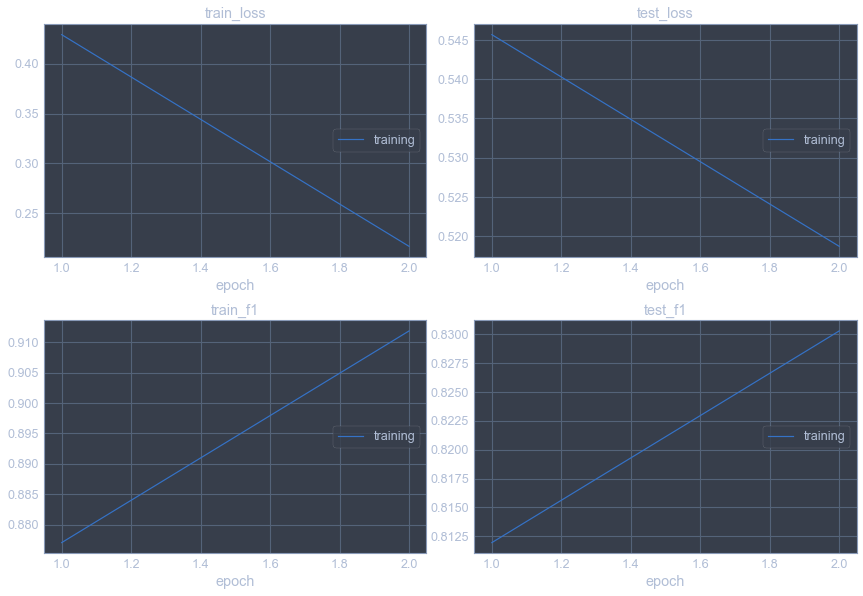

train_loss:
training   (min:    0.217, max:    0.429, cur:    0.217)

test_loss:
training   (min:    0.519, max:    0.546, cur:    0.519)

train_f1:
training   (min:    0.877, max:    0.912, cur:    0.912)

test_f1:
training   (min:    0.812, max:    0.830, cur:    0.830)


 40%|███████████████████████████████████████████████▍                                                                       | 376/943 [04:38<04:33,  2.08it/s]

In [ ]:
epochs = 4
labels = list(label_tokenizer.word_index.keys())
model = Model(fasttext_embeddings, custom_embeddings, labels, len(labels))
loss = nn.CrossEntropyLoss(weight=get_class_weights(dataset['label'], labels).to(device))
optimizer = torch.optim.Adam(model.parameters(), lr=0.0004, amsgrad=True)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.5, last_epoch=-1)
model.to(device)

train(
    epochs,
    model,
    loss,
    optimizer,
    (turn1_len, turn2_len, turn3_len),
    (te_turn1_len, te_turn2_len, te_turn3_len),
    train_batches,
    test_batches,
    scheduler=scheduler
).draw()

torch.save(model.state_dict(), 'model')

In [ ]:
t1_epochs = 5
labels = list(label_tokenizer.word_index.keys())

t1_model = Model(fasttext_embeddings, custom_embeddings, len(tier1_dataset['label'].unique()))
t1_loss = nn.CrossEntropyLoss(weight=get_class_weights(tier1_dataset['label']).to(device))
t1_optimizer = torch.optim.Adam(t1_model.parameters(), lr=0.0001, amsgrad=True)
t1_scheduler = torch.optim.lr_scheduler.ExponentialLR(t1_optimizer, gamma=0.75, last_epoch=-1)
t1_model.to(device)

train(
    t1_epochs,
    t1_model,
    t1_loss,
    t1_optimizer,
    (t1_turn1_len, t1_turn2_len, t1_turn3_len),
    t1_train_batches,
    t1_test_batches,
    scheduler=t1_scheduler
).draw()

torch.save(t1_model.state_dict(), 't1_model')
t1_model.to("cpu")
del t1_model, t1_loss, t1_optimizer, t1_train_batches, t1_test_batches

In [ ]:
t1_epochs = 4
labels = list(label_tokenizer.word_index.keys())

t1_model = Model(fasttext_embeddings, custom_embeddings, len(tier1_dataset['label'].unique()))
t1_loss = nn.CrossEntropyLoss(weight=get_class_weights(tier1_dataset['label']).to(device))
t1_optimizer = torch.optim.Adam(t1_model.parameters(), lr=0.0008, amsgrad=True)
t1_scheduler = torch.optim.lr_scheduler.ExponentialLR(t1_optimizer, gamma=0.25, last_epoch=-1)
t1_model.to(device)

train(
    t1_epochs,
    t1_model,
    t1_loss,
    t1_optimizer,
    (t1_turn1_len, t1_turn2_len, t1_turn3_len),
    (te1_turn1_len, te1_turn2_len, te1_turn3_len),
    t1_train_batches,
    t1_test_batches,
    scheduler=t1_scheduler
).draw()

torch.save(t1_model.state_dict(), 't1_model')
t1_model.to("cpu")
del t1_model, t1_loss, t1_optimizer, t1_train_batches, t1_test_batches

In [ ]:
t2_epochs = 4
labels = list(label_tokenizer.word_index.keys())

t2_model = Model(fasttext_embeddings, custom_embeddings, len(tier2_dataset['label'].unique()))
t2_loss = nn.CrossEntropyLoss(weight=get_class_weights(tier2_dataset['label']).to(device))
t2_optimizer = torch.optim.Adam(t2_model.parameters(), lr=0.0008, amsgrad=True)
t2_scheduler = torch.optim.lr_scheduler.ExponentialLR(t2_optimizer, gamma=0.20, last_epoch=-1)
t2_model.to(device)
live_loss = PlotLosses()

train(
    t2_epochs,
    t2_model,
    t2_loss,
    t2_optimizer,
    (t2_turn1_len, t2_turn2_len, t2_turn3_len),
    (te2_turn1_len, te2_turn2_len, te2_turn3_len),
    t2_train_batches,
    t2_test_batches,
    scheduler=t2_scheduler
).draw()

torch.save(t2_model.state_dict(), 't2_model')
t2_model.to("cpu")
del t2_model, t2_loss, t2_optimizer, t2_scheduler, t2_train_batches, t2_test_batches

In [ ]:
dataset = pd.read_csv('../data/testwithoutlabels.txt', sep='\t')

dataset['turn1'] = dataset['turn1'].apply(normalize)
dataset['turn2'] = dataset['turn2'].apply(normalize)
dataset['turn3'] = dataset['turn3'].apply(normalize)

turn1 = [[len(x)] + x for x in tokenizer.texts_to_sequences(dataset['turn1'].tolist())]
turn2 = [[len(x)] + x for x in tokenizer.texts_to_sequences(dataset['turn2'].tolist())]
turn3 = [[len(x)] + x for x in tokenizer.texts_to_sequences(dataset['turn3'].tolist())]

len1 = torch.stack([torch.tensor(x[0]).long() for x in turn1]).unsqueeze(1)
len2 = torch.stack([torch.tensor(x[0]).long() for x in turn2]).unsqueeze(1)
len3 = torch.stack([torch.tensor(x[0]).long() for x in turn3]).unsqueeze(1)

turn1 = torch.stack([torch.tensor(x).long() for x in pad_sequences([x[1:] for x in turn1])])
turn2 = torch.stack([torch.tensor(x).long() for x in pad_sequences([x[1:] for x in turn2])])
turn3 = torch.stack([torch.tensor(x).long() for x in pad_sequences([x[1:] for x in turn3])])

eval_data = torch.cat((len1, len2, len3,
                turn1, turn2, turn3), dim=1)
turn1_len, turn2_len, turn3_len = turn1.shape[1], turn2.shape[1], turn3.shape[1]

eval_tensors = torch.utils.data.TensorDataset(torch.tensor(eval_data.clone().detach(), dtype=torch.long))
batches = torch.utils.data.DataLoader(
    eval_tensors,
    batch_size = 128,
    pin_memory = True,
    num_workers = 8
)

t1_model = Model(fasttext_embeddings, custom_embeddings, len(tier1_dataset['label'].unique()))
t1_model.load_state_dict(torch.load('t1_model'))
t1_model.to(device)
predictions = []
predict = lambda x: torch.argmax(x, dim=1).cpu().numpy()

t1_model.eval()
for batch in tqdm(batches):
    batch = batch[0]
    max1 = torch.max(batch.narrow(1, 0, 1)).item()
    max2 = torch.max(batch.narrow(1, 1, 1)).item()
    max3 = torch.max(batch.narrow(1, 2, 1)).item()

    t1 = batch.narrow(1, 3 + turn1_len - max1, max1).to(device)
    t2 = batch.narrow(1, 3 + turn1_len + turn2_len - max2, max2).to(device)
    t3 = batch.narrow(1, 3 + turn1_len + turn2_len + turn3_len - max3, max3).to(device)

    pred = t1_model(t1, t2, t3)
    predictions = predictions + list(predict(pred))

dataset['t1_label'] = [t1_label_index[x] for x in predictions]

In [ ]:
t2_model = Model(fasttext_embeddings, custom_embeddings, len(tier2_dataset['label'].unique()))

t2_model.load_state_dict(torch.load('t2_model'))
t2_model.to(device)
t2_model.eval()
predictions = []
for batch in tqdm(batches):
    batch = batch[0]
    max1 = torch.max(batch.narrow(1, 0, 1)).item()
    max2 = torch.max(batch.narrow(1, 1, 1)).item()
    max3 = torch.max(batch.narrow(1, 2, 1)).item()

    t1 = batch.narrow(1, 3 + turn1_len - max1, max1).to(device)
    t2 = batch.narrow(1, 3 + turn1_len + turn2_len - max2, max2).to(device)
    t3 = batch.narrow(1, 3 + turn1_len + turn2_len + turn3_len - max3, max3).to(device)

    pred = t2_model(t1, t2, t3)
    predictions = predictions + list(predict(pred))

dataset['t2_label'] = [t2_label_index[x] for x in predictions]
dataset['label'] = [x[1]['t2_label'] if x[1]['t1_label'] == 'not-others' else x[1]['t1_label'] for x in dataset.iterrows()]
dataset[ ['id', 'turn1', 'turn2', 'turn3', 'label'] ].to_csv('test.txt', sep='\t', index=False)

In [ ]:
dataset[ ['id', 'turn1', 'turn2', 'turn3', 'label'] ]

In [ ]:
t2_turn1_len, t2_turn2_len, t2_turn3_len

In [ ]:
well i know he likes me it's clearly  shown

In [ ]:
t2_data.shape

In [ ]:
len([0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    2,   13,   58,    0])

In [ ]:
tier1_dataset

In [ ]:
label2_tokenizer.word_index